# Zadanie nr 4 - Odległość edycyjna

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from spacy.lang.pl import Polish

In [2]:
def print_2d(l): return print(
    '\n'.join(map(''.join, list(map(lambda x: str(x).replace("'", ""), l)))))

## 1. Odległość Levenshteina

In [3]:
LEFT = '\u2190'
UP = '\u2191'
DIAG = '\u2B09'

In [4]:
def levensheit(text_a, text_b, delta=None):
    edit = [[None for _ in range(len(text_b) + 1)]
            for _ in range(len(text_a) + 1)]
    path = [[None for _ in range(len(text_b) + 1)]
            for _ in range(len(text_a) + 1)]

    if delta is None:
        def delta(char_a, char_b): return 0 if char_a == char_b else 1

    for i in range(len(text_a) + 1):
        edit[i][0] = i
        path[i][0] = UP

    for j in range(1, len(text_b) + 1):
        edit[0][j] = j
        path[0][j] = LEFT

    for i in range(1, len(text_a)+1):
        for j in range(1, len(text_b)+1):
            options = [edit[i-1][j] + 1, edit[i][j-1] + 1,
                       edit[i-1][j-1] + delta(text_a[i-1], text_b[j-1])]
            edit[i][j] = min(options)

            if edit[i][j] == options[0]:
                path[i][j] = UP
            elif edit[i][j] == options[1]:
                path[i][j] = LEFT
            else:
                path[i][j] = DIAG

    return edit[len(text_a)][len(text_b)], edit, path

In [5]:
NEXT = 0
INSERT = 1
DELETE = 2
REPLACE = 3

In [6]:
def get_changes(text_a, text_b, edit, path):
    i, j = len(text_a), len(text_b)
    changes = []

    while i > 0 or j > 0:
        if path[i][j] == LEFT:
            changes.append([INSERT, text_b[j-1]])
            j -= 1
        elif path[i][j] == UP:
            changes.append([DELETE, text_a[i-1]])
            i -= 1
        else:
            if path[i][j] == DIAG and edit[i][j] != edit[i-1][j-1]:
                changes.append([REPLACE, text_a[i-1], text_b[j-1]])
            else:
                changes.append([NEXT])

            i -= 1
            j -= 1
    return changes

In [7]:
def transform(text_a, text_b, changes):
    i = 0
    current = text_a
    states = [current]

    for change in reversed(changes):
        if change[0] == INSERT:
            current = current[:i] + change[1] + current[i:]
            states.append(current[:i] + '*' + current[i] + '*' + current[i+1:])
        elif change[0] == REPLACE:
            current = current[:i] + change[2] + current[i+1:]
            states.append(current[:i] + '*' + current[i] + '*' + current[i+1:])
        elif change[0] == DELETE:
            current = current[:i] + current[i+1:] if i + \
                1 < len(current) else current[:i]
            states.append(current[:i]+'**'+current[i:])
            i -= 1

        i += 1

    return states

In [17]:
text_a, text_b = "kwintesencja", "quintessence"
value, edit, path = levensheit(text_a, text_b)
changes = get_changes(text_a, text_b, edit, path)
print(value)
# print_2d(changes)
print_2d(edit)
print_2d(path)

5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[3, 3, 3, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[4, 4, 4, 3, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[5, 5, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 9]
[6, 6, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8]
[7, 7, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7]
[8, 8, 8, 7, 6, 5, 4, 3, 3, 3, 4, 5, 6]
[9, 9, 9, 8, 7, 6, 5, 4, 4, 4, 3, 4, 5]
[10, 10, 10, 9, 8, 7, 6, 5, 5, 5, 4, 3, 4]
[11, 11, 11, 10, 9, 8, 7, 6, 6, 6, 5, 4, 4]
[12, 12, 12, 11, 10, 9, 8, 7, 7, 7, 6, 5, 5]
[↑, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←]
[↑, ⬉, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←]
[↑, ↑, ⬉, ←, ←, ←, ←, ←, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ⬉, ←, ←, ←, ←, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ↑, ⬉, ←, ←, ←, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ↑, ↑, ⬉, ←, ←, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ↑, ↑, ↑, ⬉, ←, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ↑, ↑, ↑, ↑, ⬉, ←, ←, ←, ←, ←]
[↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ⬉, ⬉, ←, ←, ←]
[↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ⬉, ←, ←]
[↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ↑, ⬉, ←]
[↑, ↑, ↑, ↑, ↑

#### animacja

In [36]:
def animate(states):
    fig, ax = plt.subplots(figsize=(8, 2))
    time_text = ax.text(0, 0.5, '', fontsize=40)
    plt.axis('off')

    def updatefig(num):
        time_text.set_text(states[num])
        return time_text,

    return animation.FuncAnimation(fig, updatefig, interval=500, frames=len(states))

kwintesencja
*q*wintesencja
q*u*intesencja
quintes*s*encja
quintessenc*e*a
quintessence**


<IPython.core.display.Javascript object>


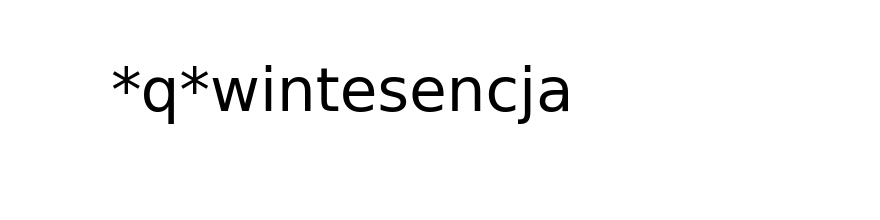

In [37]:
%matplotlib notebook
states = transform(text_a, text_b, changes)
print_2d(states)
animated = animate(states)
plt.draw()
plt.show()

## 2. Najdłuższy wspólny podciąg

## Wnioski

M. Hawryluk 30.04.2021